# Brain Tumor MRI Image Classification

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
base_path = "Tumour"

train_dir = os.path.join(base_path, "train")
valid_dir = os.path.join(base_path, "valid")
test_dir  = os.path.join(base_path, "test")

print(train_dir)
print(test_dir)
print(valid_dir)

Tumour\train
Tumour\test
Tumour\valid


# Understand the data 

In [4]:
classes = [cls for cls in os.listdir(train_dir)
           if os.path.isdir(os.path.join(train_dir, cls))]

print("Tumor Categories:", classes)
print("Number of Classes:", len(classes))

Tumor Categories: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Number of Classes: 4


In [5]:
# Displaying the sample images 

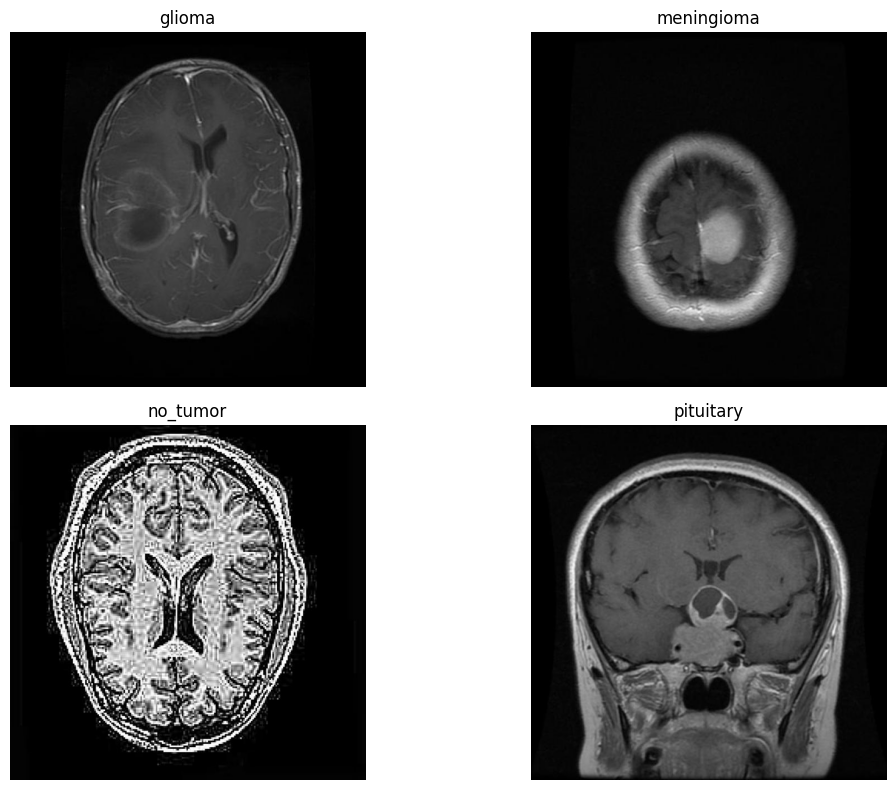

In [6]:
import random
plt.figure(figsize=(12,8))


for i, cls in enumerate(classes):
    img_path = random.choice(os.listdir(os.path.join(train_dir, cls)))
    img_full_path = os.path.join(train_dir, cls, img_path)
    
    img = Image.open(img_full_path)
    
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [7]:
# Check class imbalance

In [8]:
class_counts = {}

for cls in classes:
    class_counts[cls] = len(os.listdir(os.path.join(train_dir, cls)))

print("Class Distribution:")
print(class_counts)


Class Distribution:
{'glioma': 564, 'meningioma': 358, 'no_tumor': 335, 'pituitary': 438}


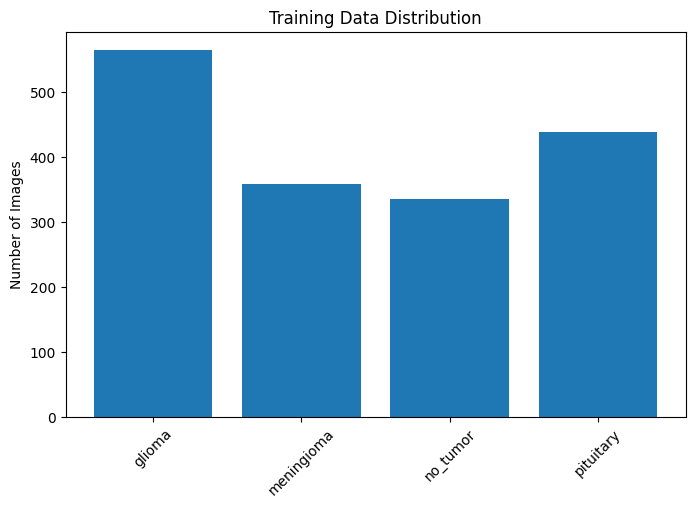

In [9]:
plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Training Data Distribution")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.show()


In [10]:
# Check Image Resolution Consistency

In [11]:
image_sizes = []

for cls in classes:
    folder = os.path.join(train_dir, cls)
    for img_name in os.listdir(folder)[:50]:
        img_path = os.path.join(folder, img_name)
        img = Image.open(img_path)
        image_sizes.append(img.size)

unique_sizes = set(image_sizes)

print("Unique Image Sizes Found:", unique_sizes)

Unique Image Sizes Found: {(640, 640)}


# Data Preprocessing And Augmentation

In [12]:
image_size = 224 
batch_size = 32

In [20]:
img, label = train_dataset[0]
print("Image shape:", img.shape)


Image shape: torch.Size([3, 224, 224])


In [21]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),      # Resize to 224x224
    
    transforms.RandomHorizontalFlip(p=0.5),           # 50% chance horizontal flip
    transforms.RandomVerticalFlip(p=0.3),             # 30% chance vertical flip
    transforms.RandomRotation(20),                    # Rotate between -20° to +20°
    
    transforms.ColorJitter(                           # Brightness & contrast variation
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),  # Zoom effect
    
    transforms.ToTensor(),                            # Convert to Tensor (0–255 → 0–1)
])

valid_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),      # Only resize
    transforms.ToTensor(),                            # Only normalize
])

In [16]:
# Load Dataset With Transform 

In [17]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(train_dir, transform=train_transform)
valid_dataset = ImageFolder(valid_dir, transform=valid_transform)
test_dataset  = ImageFolder(test_dir,  transform=valid_transform)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)    #training mai shuffle jruri hai agr data order same rha to model boased ho skta hai 
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)   # Validation/Test me shuffle nahi karte Kyuki performance stable check karna hota hai.
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("Classes:", train_dataset.classes)

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


In [19]:
images, labels = next(iter(train_loader))
print(images.shape)

torch.Size([32, 3, 224, 224])


# Model Building

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()

        # Block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Block 2
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        # Block 3
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2,2)

        self.dropout = nn.Dropout(0.5)

        # Adaptive pooling instead of manual flatten size
        self.gap = nn.AdaptiveAvgPool2d((1,1))

        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = self.gap(x)   # Global Average Pooling

        x = x.view(x.size(0), -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x


# Training Custom CNN

In [23]:
model = BrainTumorCNN(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.9,
    weight_decay=1e-4
)

num_epochs = 30
patience = 7


In [24]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
counter = 0


In [25]:
for epoch in range(num_epochs):as

    # -------- TRAINING --------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # -------- VALIDATION --------
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(valid_loader)
    val_accuracy = 100 * val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # -------- ModelCheckpoint --------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_custom_cnn.pth")
        counter = 0
        print(" Best model save!")
    else:
        counter += 1

    # -------- EarlyStopping --------
    if counter >= patience:
        print(" Early stopping triggered")
        break

Epoch [1/30] Train Loss: 42.0899 | Train Acc: 41.24% Val Loss: 1.2600 | Val Acc: 50.00%
 Best model save!
Epoch [2/30] Train Loss: 37.3978 | Train Acc: 53.45% Val Loss: 1.0772 | Val Acc: 59.76%
 Best model save!
Epoch [3/30] Train Loss: 34.1466 | Train Acc: 60.35% Val Loss: 1.0064 | Val Acc: 61.75%
 Best model save!
Epoch [4/30] Train Loss: 32.2873 | Train Acc: 60.94% Val Loss: 0.9077 | Val Acc: 64.14%
 Best model save!
Epoch [5/30] Train Loss: 29.9393 | Train Acc: 63.13% Val Loss: 0.8402 | Val Acc: 68.13%
 Best model save!
Epoch [6/30] Train Loss: 29.1515 | Train Acc: 64.96% Val Loss: 0.8863 | Val Acc: 65.34%
Epoch [7/30] Train Loss: 28.4713 | Train Acc: 65.25% Val Loss: 0.8117 | Val Acc: 65.94%
 Best model save!
Epoch [8/30] Train Loss: 27.3352 | Train Acc: 65.55% Val Loss: 0.7868 | Val Acc: 66.53%
 Best model save!
Epoch [9/30] Train Loss: 26.5114 | Train Acc: 67.73% Val Loss: 0.8463 | Val Acc: 67.93%
Epoch [10/30] Train Loss: 25.6058 | Train Acc: 68.44% Val Loss: 0.7252 | Val Acc: 

# Model Evaluation 

In [26]:
model = BrainTumorCNN(num_classes=4).to(device)
model.load_state_dict(torch.load("best_custom_cnn.pth"))
model.eval()

BrainTumorCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (gap): AdaptiveAvgPool2d

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())


In [28]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy*100:.2f}%\n")

print("Classification Report:\n")
print(classification_report(all_labels, all_preds))


Accuracy: 77.09%

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.98      0.83       161
           1       0.85      0.35      0.50       124
           2       0.79      0.86      0.82        99
           3       0.82      0.86      0.84       118

    accuracy                           0.77       502
   macro avg       0.79      0.76      0.75       502
weighted avg       0.79      0.77      0.75       502



In [29]:
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n")
print(cm)


Confusion Matrix:

[[157   3   0   1]
 [ 44  44  21  15]
 [  6   2  85   6]
 [ 12   3   2 101]]


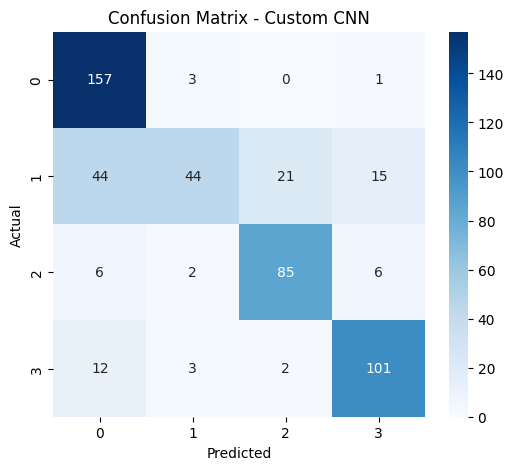

In [31]:
# Optional Better visualization 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Custom CNN")
plt.show()


In [32]:
train_losses
val_losses
train_accuracies
val_accuracies


[50.0,
 59.7609561752988,
 61.75298804780876,
 64.14342629482071,
 68.12749003984064,
 65.33864541832669,
 65.93625498007968,
 66.53386454183267,
 67.92828685258964,
 73.10756972111554,
 60.756972111553786,
 75.4980079681275,
 71.91235059760956,
 65.93625498007968,
 59.7609561752988,
 65.33864541832669,
 77.09163346613546,
 73.10756972111554,
 55.776892430278885,
 56.77290836653386,
 64.34262948207171,
 69.7211155378486,
 71.31474103585657,
 67.52988047808765]

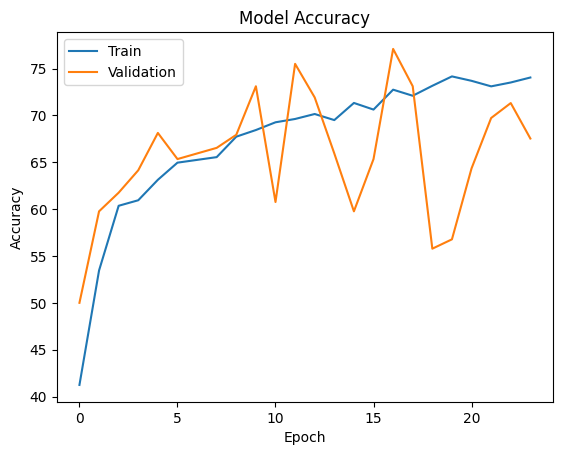

In [33]:
# Accuracy plot
plt.figure()
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"])
plt.show()


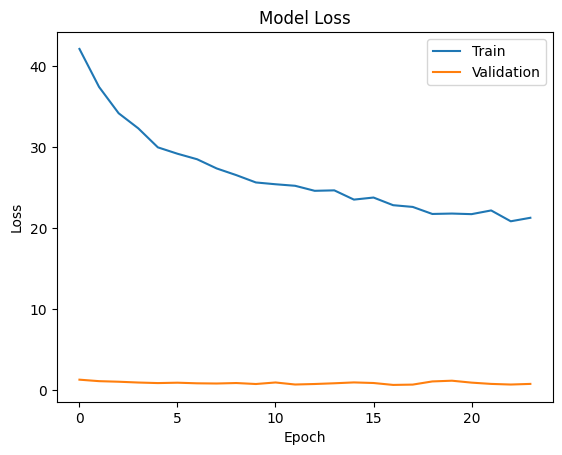

In [34]:
# Loss Plot
plt.figure()
plt.plot(train_losses)
plt.plot(val_losses)
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()

# Transfer Learning

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [37]:
model = models.resnet50(pretrained=True)

C:\Users\mukul\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mukul\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\mukul/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


100.0%


In [38]:
for param in model.parameters():
    param.requires_grad = False

In [39]:
num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [40]:
print(model.fc)

Linear(in_features=2048, out_features=4, bias=True)


In [41]:
model = model.to(device)

In [42]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [46]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [47]:
num_epochs = 20
best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):

    # -------- TRAIN --------
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader)
    train_acc = 100 * correct / total


    # -------- VALIDATION --------
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(valid_loader)
    val_acc = 100 * correct / total


    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # -------- EARLY STOPPING --------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_resnet50.pth")
        counter = 0
        print(" Best model saved!")
    else:
        counter += 1
        if counter >= patience:
            print(" Early stopping triggered")
            break


Epoch [1/20] Train Loss: 0.3402 | Train Acc: 86.73% Val Loss: 0.4823 | Val Acc: 82.07%
 Best model saved!
Epoch [2/20] Train Loss: 0.3510 | Train Acc: 87.20% Val Loss: 0.4350 | Val Acc: 86.25%
 Best model saved!
Epoch [3/20] Train Loss: 0.3342 | Train Acc: 88.14% Val Loss: 0.3604 | Val Acc: 89.04%
 Best model saved!
Epoch [4/20] Train Loss: 0.3428 | Train Acc: 87.02% Val Loss: 0.3696 | Val Acc: 89.24%
Epoch [5/20] Train Loss: 0.3508 | Train Acc: 87.26% Val Loss: 0.3949 | Val Acc: 87.25%
Epoch [6/20] Train Loss: 0.3358 | Train Acc: 86.84% Val Loss: 0.5739 | Val Acc: 78.69%
Epoch [7/20] Train Loss: 0.3285 | Train Acc: 88.50% Val Loss: 0.4394 | Val Acc: 86.65%
Epoch [8/20] Train Loss: 0.3225 | Train Acc: 87.79% Val Loss: 0.4548 | Val Acc: 84.26%
 Early stopping triggered


# Model Evaluation 

In [48]:
model.load_state_dict(torch.load("best_resnet50.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 


Test Accuracy: 87.80%

Classification Report:

              precision    recall  f1-score   support

      glioma       0.93      0.96      0.94        80
  meningioma       0.84      0.76      0.80        63
    no_tumor       0.83      0.82      0.82        49
   pituitary       0.88      0.94      0.91        54

    accuracy                           0.88       246
   macro avg       0.87      0.87      0.87       246
weighted avg       0.88      0.88      0.88       246



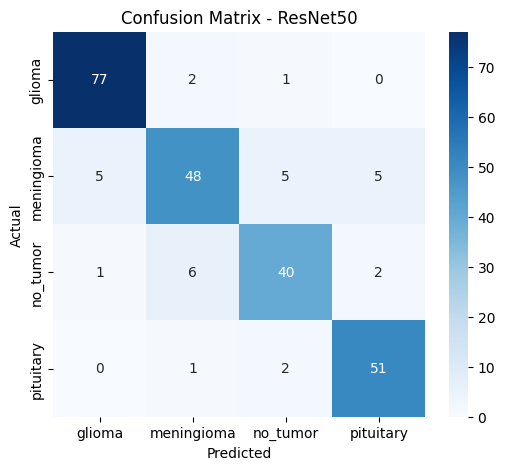

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%\n")

# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ResNet50")
plt.show()


# Model Comparison

In [50]:
custom_model = BrainTumorCNN(num_classes=4).to(device)
custom_model.load_state_dict(torch.load("best_custom_cnn.pth"))
custom_model.eval()

BrainTumorCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (gap): AdaptiveAvgPool2d

In [51]:
from sklearn.metrics import accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = custom_model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

custom_test_accuracy = accuracy_score(all_labels, all_preds)

print(f"Custom CNN Test Accuracy: {custom_test_accuracy*100:.2f}%")


Custom CNN Test Accuracy: 74.80%


In [53]:
resnet_test_accuracy = test_accuracy

In [54]:
print("\nModel Comparison:\n")
print(f"Custom CNN Test Accuracy  : {custom_test_accuracy*100:.2f}%")
print(f"ResNet50 Test Accuracy    : {resnet_test_accuracy*100:.2f}%")


Model Comparison:

Custom CNN Test Accuracy  : 74.80%
ResNet50 Test Accuracy    : 87.80%


# Visual Comparison Graph 

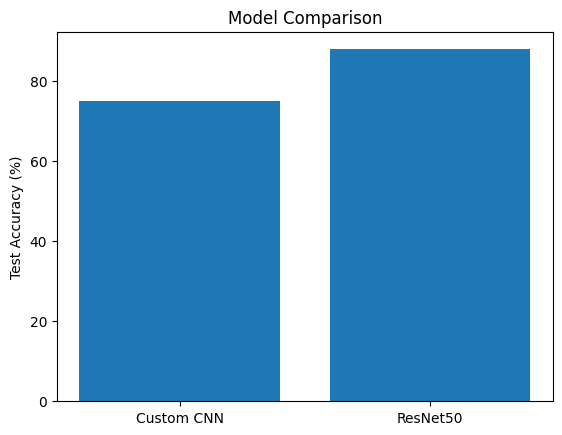

In [55]:
import matplotlib.pyplot as plt

models = ["Custom CNN", "ResNet50"]
accuracies = [custom_test_accuracy * 100, resnet_test_accuracy * 100]

plt.figure()
plt.bar(models, accuracies)
plt.ylabel("Test Accuracy (%)")
plt.title("Model Comparison")
plt.show()

In [56]:
import os
print(os.getcwd())

C:\Users\mukul\brain_tumour_classification
